In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm



sys.path.insert(0, os.path.abspath("python_packages"))
from python_packages import *
from src import *



# Also add the current directory to ensure all modules can be found
sys.path.append('.')

# Ideas
Training two networks - on CC and MLO images - View_Cancer dataloader to later use Breast_dataloader and ajive them to check the joint component.

In [3]:
breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="images_png_396",
    image_format="png",
    norm_kind="dataset_zscore",
    batch_size=32,  
    num_workers=1,
    task=1,
)
model_MLO = Single_view_model.load_from_checkpoint('artifacts/model-gvwwbcjp:v0/model.ckpt')
model_CC = Single_view_model.load_from_checkpoint('artifacts/model-z6qm6vzp:v0/model.ckpt')

In [4]:
def get_featurized_data(dataloader, model, model1):
    """
    Get the full featurized dataset from a dataloader.
    """
    model.to('mps')
    model.eval()
    model1.to('mps')
    model1.eval()
    with torch.no_grad():
        all_MLO_features = []
        all_CC_features = []

        all_labels = []

        for batch in tqdm.tqdm(dataloader, desc="Featurizing dataset"):
            x, y1, y2 = batch
            y = y1 if model.task == 1 else y2
            x = [item.to('mps') for item in x]
            y = y.to('mps')
            all_labels.append(y)

            x_MLO = [model.resnet(x[1])]

            x_CC = [model1.resnet(x[0])]

            all_MLO_features.append(torch.cat(x_MLO, dim=1))

            all_CC_features.append(torch.cat(x_CC, dim=1))

        all_MLO_features = torch.cat(all_MLO_features, dim=0)
        all_CC_features = torch.cat(all_CC_features, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

    return all_MLO_features, all_CC_features, all_labels

In [5]:
def process_and_save_all_splits(breast_loader, model_MLO, model_CC, save_dir='saved_features'):
    """
    Process train, test, and validation dataloaders and save features and labels.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    splits = {
        'train': breast_loader.train_dataloader(),
        'val': breast_loader.val_dataloader(),
        'test': breast_loader.test_dataloader()
    }
    
    for split_name, dataloader in splits.items():
        print(f"Processing {split_name} split...")
        
        MLO_features, CC_features, labels = get_featurized_data(
            dataloader, model_MLO, model_CC
        )
        
        # Move to CPU before saving
        MLO_features = MLO_features.cpu()
        CC_features = CC_features.cpu()
        labels = labels.cpu()

        # Save features and labels separately
        torch.save(MLO_features, f'{save_dir}/MLO_features_{split_name}.pt')
        torch.save(CC_features, f'{save_dir}/CC_features_{split_name}.pt')
        torch.save(labels, f'{save_dir}/labels_{split_name}.pt')

        # Also save as dictionary for convenience
        torch.save({
            'MLO_features': MLO_features,
            'CC_features': CC_features,
            'labels': labels
        }, f'{save_dir}/all_data_{split_name}.pt')
        
        print(f"Saved {split_name} split with shapes:")
        print(f"  MLO features: {MLO_features.shape}")
        print(f"  CC features: {CC_features.shape}")
        print(f"  Labels: {labels.shape}")
        print()

# Run the processing and saving
#process_and_save_all_splits(breast_loader, model, model_dens)

In [6]:
#process_and_save_all_splits(breast_loader, model_MLO, model_CC, save_dir='saved_features/MLOvsCC')

In [7]:
train_data = torch.load('saved_features/MLOvsCC/all_data_train.pt')
train_MLO_features = train_data['MLO_features'].numpy()
train_CC_features = train_data['CC_features'].numpy()
train_cancer_labels = train_data['labels'].numpy()


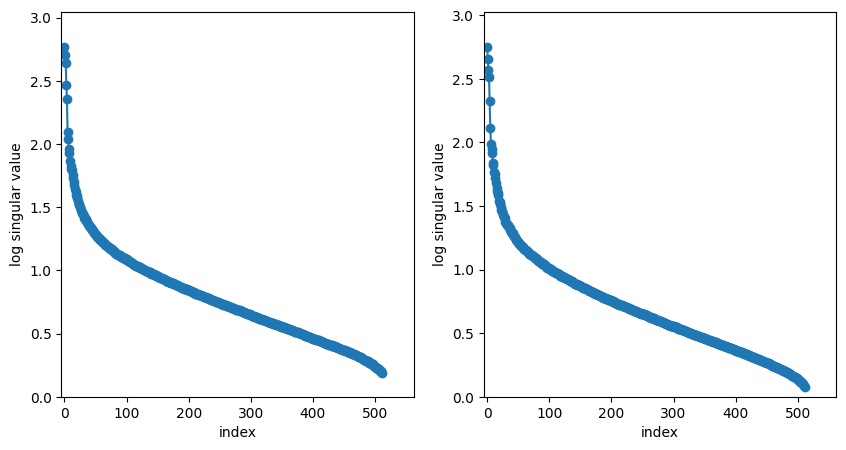

In [8]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(train_MLO_features).plot_scree(log = True)
plt.subplot(1, 2, 2)
PCA().fit(train_CC_features).plot_scree(log = True)

In [9]:
aj = AJIVE(init_signal_ranks=[20,20], n_jobs=16, center=True)
aj.fit([train_MLO_features, train_CC_features])
aj.summary()


'AJIVE, joint rank: 5, view 0 indiv rank: 16, view 1 indiv rank: 17'

In [10]:
val_data = torch.load('saved_features/MLOvsCC/all_data_val.pt')
val_MLO_features = val_data['MLO_features'].numpy()
val_CC_features = val_data['CC_features'].numpy()
val_labels = val_data['labels'].numpy()

test_data = torch.load('saved_features/MLOvsCC/all_data_test.pt')
test_MLO_features = test_data['MLO_features'].numpy()
test_CC_features = test_data['CC_features'].numpy()
test_labels = test_data['labels'].numpy()


In [11]:
# Create enriched features with consistent transformations
train_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(train_MLO_features), aj.view_specific_[1].joint_.transform(train_CC_features)])
val_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(val_MLO_features), aj.view_specific_[1].joint_.transform(val_CC_features)])
test_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(test_MLO_features), aj.view_specific_[1].joint_.transform(test_CC_features)])

train_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(train_MLO_features), aj.view_specific_[1].individual_.transform(train_CC_features)])
val_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(val_MLO_features), aj.view_specific_[1].individual_.transform(val_CC_features)])
test_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(test_MLO_features), aj.view_specific_[1].individual_.transform(test_CC_features)])

# Combined enriched features (joint + individual)
train_cancer_enriched = np.hstack([train_joint_components, train_individual_components])
val_cancer_enriched = np.hstack([val_joint_components, val_individual_components])
test_cancer_enriched = np.hstack([test_joint_components, test_individual_components])

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score

In [22]:
from sklearn.metrics import f1_score, balanced_accuracy_score

def evaluate_svm_classifier(X_train, y_train, X_val, y_val, X_test, y_test, feature_name):
    """
    Train and evaluate an RBF SVM classifier with comprehensive metrics
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train RBF SVM
    svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)
    
    # Make predictions
    test_pred = svm_classifier.predict(X_test_scaled)
    
    # Calculate comprehensive metrics
    test_acc_macro = balanced_accuracy_score(y_test, test_pred)  # Overall accuracy
    test_f1_macro = f1_score(y_test, test_pred, average='macro')
    test_f1_weighted = f1_score(y_test, test_pred, average='weighted')
    
    # Per-class metrics
    from sklearn.metrics import classification_report
    class_report = classification_report(y_test, test_pred, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    
    # Cross-validation scores
    cv_scores_acc = cross_val_score(svm_classifier, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores_f1 = cross_val_score(svm_classifier, X_train_scaled, y_train, cv=5, scoring='f1_macro')
    
    results = {
        'feature_name': feature_name,
        'feature_dims': X_train.shape[1],
        'test_acc_macro': test_acc_macro,
        'test_f1_macro': test_f1_macro,
        'test_f1_weighted': test_f1_weighted,
        'cv_acc_mean': cv_scores_acc.mean(),
        'cv_acc_std': cv_scores_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'confusion_matrix': cm,
        'classification_report': class_report,
        'test_predictions': test_pred,
        'test_labels': y_test
    }
    
    return results, svm_classifier

In [ ]:
# CLEAN EXECUTION - Force fresh run and clear display issues
from IPython.display import clear_output
import time

# Clear all previous output from this notebook session
clear_output(wait=True)
time.sleep(0.5)

# Delete existing results to force fresh execution
if 'all_results' in globals():
    print(f"Deleting existing all_results with {len(all_results)} items")
    del all_results
    
# Force garbage collection
import gc
gc.collect()

# Create a modified version with unique execution tracking
def compare_feature_transformations_svm_clean():
    """
    Clean version with execution tracking to prevent duplicate display
    """
    import time
    execution_id = int(time.time() * 1000) % 100000  # Unique 5-digit ID
    
    # Define feature sets to compare
    feature_sets = [
        ('MLO Features Only', train_MLO_features, val_MLO_features, test_MLO_features),
        ('CC Features Only', train_CC_features, val_CC_features, test_CC_features),
        ('Concatenated (MLO + CC)', 
         np.hstack([train_MLO_features, train_CC_features]),
         np.hstack([val_MLO_features, val_CC_features]),
         np.hstack([test_MLO_features, test_CC_features])),
        ('Joint Components Only', train_joint_components, val_joint_components, test_joint_components),
        ('Individual Components Only', train_individual_components, val_individual_components, test_individual_components),
        ('AJIVE Enriched (Joint + Individual)', train_cancer_enriched, val_cancer_enriched, test_cancer_enriched)
    ]
    
    # Store results
    all_results = []
    
    print(f"Execution ID: {execution_id}")
    print("Comparing Feature Transformations with RBF SVM...")
    print("=" * 70)
    
    for i, (feature_name, X_train, X_val, X_test) in enumerate(feature_sets):
        print(f"\n[{i+1}/{len(feature_sets)}] 🔍 {feature_name}")
        print(f"Dimensions: {X_train.shape[1]} | ID: {execution_id}")
        print("-" * 50)
        
        try:
            results, trained_svm = evaluate_svm_classifier(
                X_train, train_cancer_labels,
                X_val, val_labels,
                X_test, test_labels,
                feature_name
            )
            all_results.append(results)
            
            print(f" Accuracy: {results['test_acc_macro']:.4f} | F1: {results['test_f1_macro']:.4f}")
            print(f" CV: {results['cv_f1_mean']:.4f} ± {results['cv_f1_std']:.4f}")
            
        except Exception as e:
            print(f" ERROR: {str(e)}")
    
    print(f"\n Execution {execution_id} completed: {len(all_results)} evaluations")
    return all_results

# Execute the clean version
all_results = compare_feature_transformations_svm_clean()

print(f"\n Final Summary:")
print(f"Total results: {len(all_results)}")
for i, result in enumerate(all_results):
    print(f"  {i+1}. {result['feature_name']}: F1={result['test_f1_macro']:.4f}")

Deleting existing all_results with 0 items
Execution ID: 95200
Comparing Feature Transformations with RBF SVM...

[1/6] 🔍 MLO Features Only
Dimensions: 512 | ID: 95200
--------------------------------------------------
 Accuracy: 0.4348 | F1: 0.4593
 F1 Weighted: 0.7105
 CV: 0.8926 ± 0.0107

[2/6] 🔍 CC Features Only
Dimensions: 512 | ID: 95200
--------------------------------------------------
 Accuracy: 0.4342 | F1: 0.4547
 F1 Weighted: 0.7078
 CV: 0.8895 ± 0.0131

[3/6] 🔍 Concatenated (MLO + CC)
Dimensions: 1024 | ID: 95200
--------------------------------------------------
 Accuracy: 0.4349 | F1: 0.4723
 F1 Weighted: 0.7350
 CV: 0.9277 ± 0.0068

[4/6] 🔍 Joint Components Only
Dimensions: 10 | ID: 95200
--------------------------------------------------
 Accuracy: 0.4323 | F1: 0.4655
 F1 Weighted: 0.7165
 CV: 0.9105 ± 0.0088

[5/6] 🔍 Individual Components Only
Dimensions: 33 | ID: 95200
--------------------------------------------------
 Accuracy: 0.4364 | F1: 0.4727
 F1 Weighted: 0.7

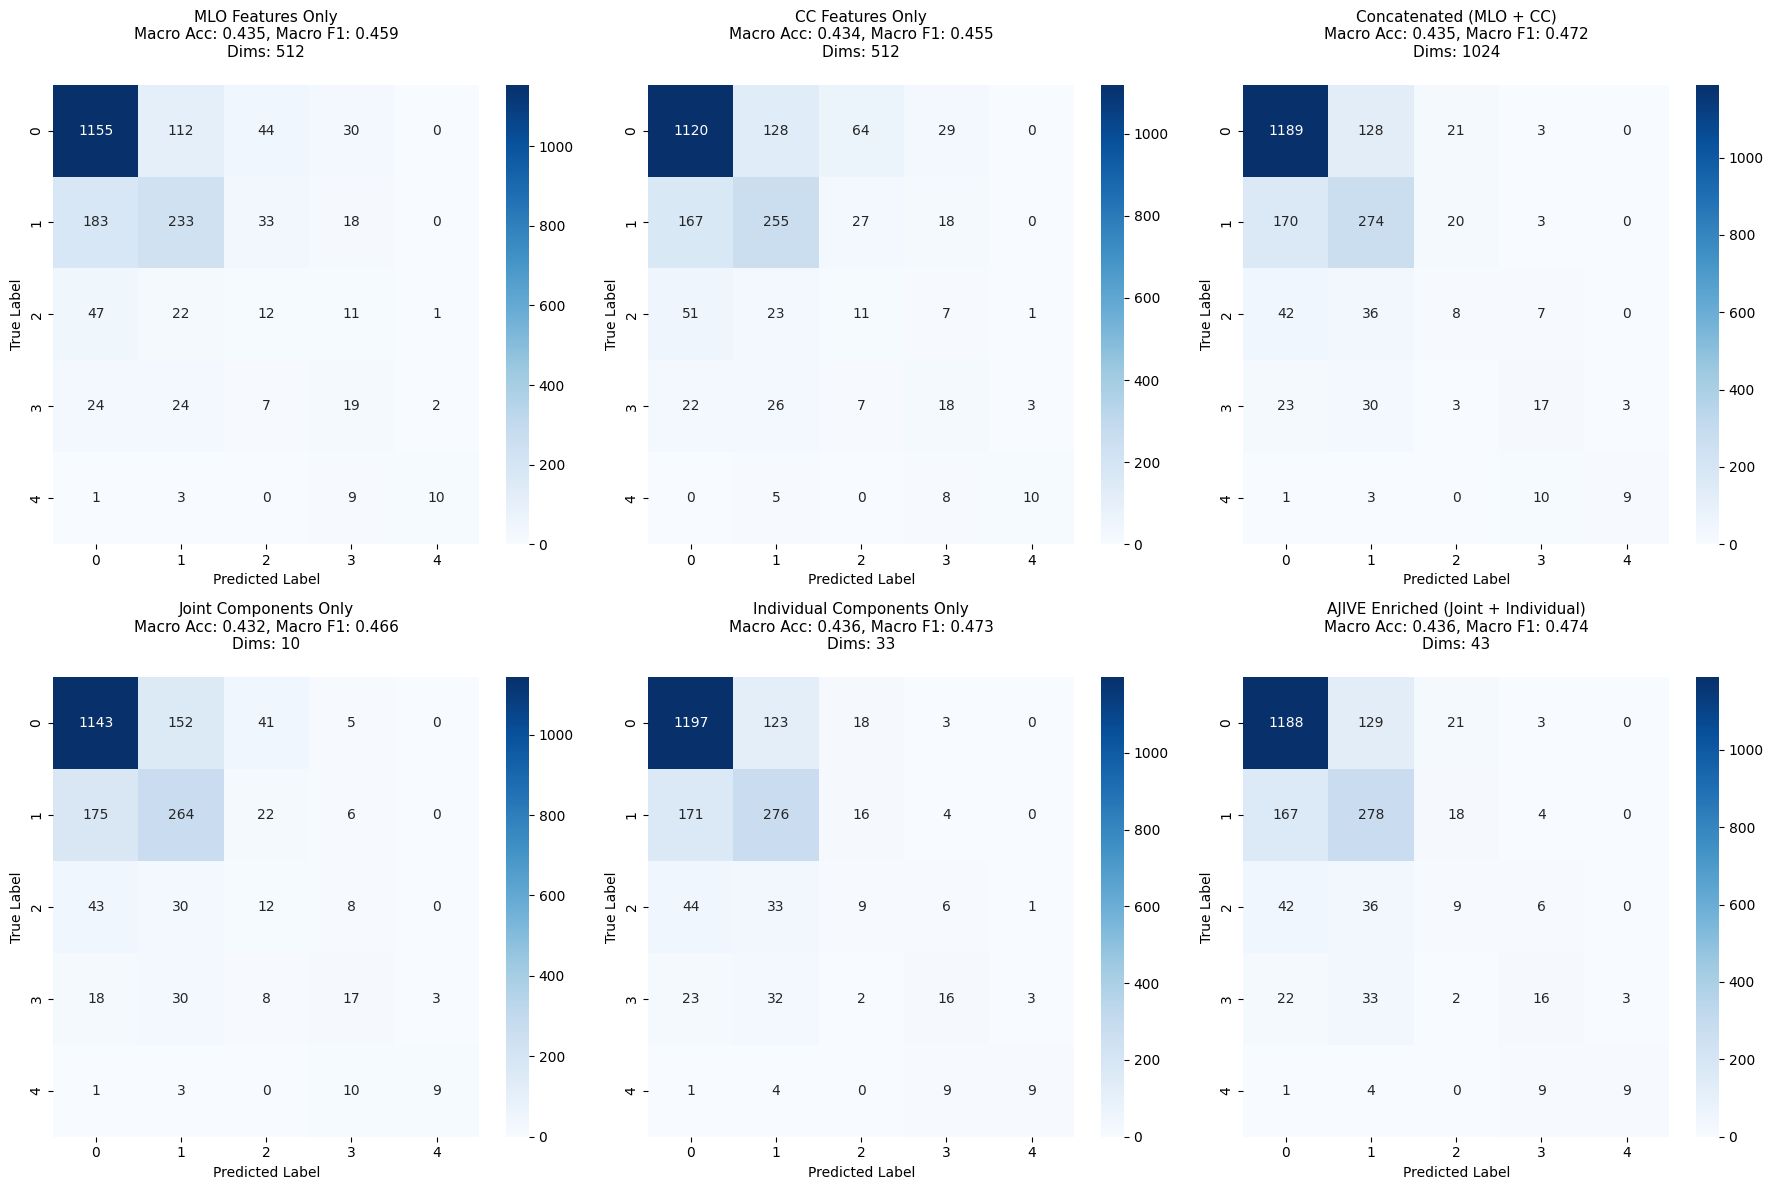

In [25]:
def plot_confusion_matrices_comparison(all_results):
    """
    Create a comprehensive confusion matrix comparison plot
    """
    n_methods = len(all_results)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Get unique class labels
    all_labels = set()
    for result in all_results:
        all_labels.update(result['test_labels'])
        all_labels.update(result['test_predictions'])
    class_labels = sorted(list(all_labels))
    
    for idx, result in enumerate(all_results):
        ax = axes[idx]
        
        # Plot confusion matrix
        cm = result['confusion_matrix']
        im = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                        xticklabels=class_labels, yticklabels=class_labels)
        
        # Add title with metrics
        title = f"{result['feature_name']}\n"
        title += f"Macro Acc: {result['test_acc_macro']:.3f}, "
        title += f"Macro F1: {result['test_f1_macro']:.3f}\n"
        title += f"Dims: {result['feature_dims']}"
        
        ax.set_title(title, fontsize=11, pad=20)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    
    # Remove empty subplots if any
    for idx in range(n_methods, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_performance_summary(all_results):
    """
    Create comprehensive performance summary
    """
    # Convert to DataFrame for easier analysis
    summary_data = []
    for result in all_results:
        summary_data.append({
            'Feature_Type': result['feature_name'],
            'Dimensions': result['feature_dims'],
            'Test_Acc_Macro': result['test_acc_macro'],
            'Test_F1_Macro': result['test_f1_macro'],
            'Test_F1_Weighted': result['test_f1_weighted'],
            'CV_Acc_Mean': result['cv_acc_mean'],
            'CV_Acc_Std': result['cv_acc_std'],
            'CV_F1_Mean': result['cv_f1_mean'],
            'CV_F1_Std': result['cv_f1_std']
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Sort by macro F1 score
    summary_df = summary_df.sort_values('Test_F1_Macro', ascending=False)
    
    print("=" * 80)
    print("PERFORMANCE SUMMARY - RBF SVM RESULTS")
    print("=" * 80)
    print(summary_df.round(4).to_string(index=False))
    
    # Create performance comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Macro Accuracy vs F1 Score
    axes[0,0].scatter(summary_df['Test_Acc_Macro'], summary_df['Test_F1_Macro'], s=100, alpha=0.7)
    for i, txt in enumerate(summary_df['Feature_Type']):
        axes[0,0].annotate(txt.split(' ')[0], (summary_df['Test_Acc_Macro'].iloc[i], 
                          summary_df['Test_F1_Macro'].iloc[i]), xytext=(5,5), 
                          textcoords='offset points', fontsize=8)
    axes[0,0].set_xlabel('Test Accuracy (Macro)')
    axes[0,0].set_ylabel('Test F1 Score (Macro)')
    axes[0,0].set_title('Accuracy vs F1 Score')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Performance vs Dimensionality
    axes[0,1].scatter(summary_df['Dimensions'], summary_df['Test_F1_Macro'], s=100, alpha=0.7)
    for i, txt in enumerate(summary_df['Feature_Type']):
        axes[0,1].annotate(txt.split(' ')[0], (summary_df['Dimensions'].iloc[i], 
                          summary_df['Test_F1_Macro'].iloc[i]), xytext=(5,5), 
                          textcoords='offset points', fontsize=8)
    axes[0,1].set_xlabel('Feature Dimensions')
    axes[0,1].set_ylabel('Test F1 Score (Macro)')
    axes[0,1].set_title('Performance vs Dimensionality')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Cross-validation comparison
    x_pos = np.arange(len(summary_df))
    axes[1,0].bar(x_pos, summary_df['CV_F1_Mean'], yerr=summary_df['CV_F1_Std'], 
                  capsize=5, alpha=0.7)
    axes[1,0].set_xlabel('Feature Type')
    axes[1,0].set_ylabel('CV F1 Score (Macro)')
    axes[1,0].set_title('Cross-Validation F1 Performance')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels([name.split(' ')[0] for name in summary_df['Feature_Type']], 
                             rotation=45, ha='right')
    
    # 4. Macro vs Weighted F1
    axes[1,1].scatter(summary_df['Test_F1_Macro'], summary_df['Test_F1_Weighted'], s=100, alpha=0.7)
    for i, txt in enumerate(summary_df['Feature_Type']):
        axes[1,1].annotate(txt.split(' ')[0], (summary_df['Test_F1_Macro'].iloc[i], 
                          summary_df['Test_F1_Weighted'].iloc[i]), xytext=(5,5), 
                          textcoords='offset points', fontsize=8)
    axes[1,1].set_xlabel('Test F1 Score (Macro)')
    axes[1,1].set_ylabel('Test F1 Score (Weighted)')
    axes[1,1].set_title('Macro vs Weighted F1')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return summary_df

# Create visualizations
confusion_fig = plot_confusion_matrices_comparison(all_results)
#summary_df = create_performance_summary(all_results)

# Use a fixed feature extractor (Mirai) to extract features from CC and MLO and then compare those

In [59]:
sys.path.append('Mirai_Risk_Prediction_Model')
from Mirai_Risk_Prediction_Model.asymmetry_model.mirai_localized_dif_head import extract_mirai_backbone
encoder = extract_mirai_backbone('Mirai_Risk_Prediction_Model/asymmetry_model/mgh_mammo_MIRAI_Base_May20_2019.p')

In [60]:
import torch.nn as nn

breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="New_512",
    image_format="dicom",
    norm_kind="dataset_zscore",
    batch_size=32,  
    num_workers=1,
    task=1,
)

#model = Four_view_single_featurizer(5, weights_file = 'checkpoints/One_view_resnet.ckpt')

# First tried the mirai encoder, but it didnt give good features at all - maybe different preprocessing?
mirai_feature_extractor = nn.Sequential(
    encoder,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)
#mirai_feature_extractor(torch.randn(5,3,512,512)).shape
#model.resnet(torch.randn(5,3,512,512)).shape


In [61]:
def get_featurized_data(dataloader, model, task = 1):
    """
    Get the full featurized dataset from a dataloader. Using one mirai featurizer
    """
    model.to('mps')
    model.eval()
    with torch.no_grad():
        all_MLO_features = []
        all_CC_features = []

        all_labels = []

        for batch in tqdm.tqdm(dataloader, desc="Featurizing dataset"):
            x, y1, y2 = batch
            y = y1 if task == 1 else y2
            x = [item.to('mps') for item in x]
            y = y.to('mps')
            all_labels.append(y)

            x_CC = [model(x[0])]

            x_MLO = [model(x[1])]

            all_MLO_features.append(torch.cat(x_MLO, dim=1))

            all_CC_features.append(torch.cat(x_CC, dim=1))

        all_MLO_features = torch.cat(all_MLO_features, dim=0)
        all_CC_features = torch.cat(all_CC_features, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

    return all_MLO_features, all_CC_features, all_labels

In [62]:
def process_and_save_all_splits(breast_loader, model, save_dir='saved_features/cc+MLO_mirai/'):
    """
    Process train, test, and validation dataloaders and save features and labels.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    splits = {
        'train': breast_loader.train_dataloader(),
        'val': breast_loader.val_dataloader(),
        'test': breast_loader.test_dataloader()
    }
    
    for split_name, dataloader in splits.items():
        print(f"Processing {split_name} split...")
        
        MLO_features, CC_features, labels = get_featurized_data(
            dataloader, model
        )
        
        # Move to CPU before saving
        MLO_features = MLO_features.cpu()
        CC_features = CC_features.cpu()
        labels = labels.cpu()

        # Save features and labels separately
        torch.save(MLO_features, f'{save_dir}/MLO_features_{split_name}.pt')
        torch.save(CC_features, f'{save_dir}/CC_features_{split_name}.pt')
        torch.save(labels, f'{save_dir}/labels_{split_name}.pt')

        # Also save as dictionary for convenience
        torch.save({
            'MLO_features': MLO_features,
            'CC_features': CC_features,
            'labels': labels
        }, f'{save_dir}/all_data_{split_name}.pt')
        
        print(f"Saved {split_name} split with shapes:")
        print(f"  MLO features: {MLO_features.shape}")
        print(f"  CC features: {CC_features.shape}")
        print(f"  Labels: {labels.shape}")
        print()

In [63]:
process_and_save_all_splits(breast_loader, mirai_feature_extractor)

Processing train split...


Featurizing dataset: 100%|██████████| 200/200 [05:07<00:00,  1.54s/it]


Saved train split with shapes:
  MLO features: torch.Size([6400, 512])
  CC features: torch.Size([6400, 512])
  Labels: torch.Size([6400])

Processing val split...


Featurizing dataset: 100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


Saved val split with shapes:
  MLO features: torch.Size([1598, 512])
  CC features: torch.Size([1598, 512])
  Labels: torch.Size([1598])

Processing test split...


Featurizing dataset: 100%|██████████| 63/63 [01:41<00:00,  1.61s/it]


Saved test split with shapes:
  MLO features: torch.Size([2000, 512])
  CC features: torch.Size([2000, 512])
  Labels: torch.Size([2000])



In [64]:
train_data = torch.load('saved_features/cc+MLO_mirai/all_data_train.pt')
train_MLO_features = train_data['MLO_features'].numpy()
train_CC_features = train_data['CC_features'].numpy()
train_cancer_labels = train_data['labels'].numpy()


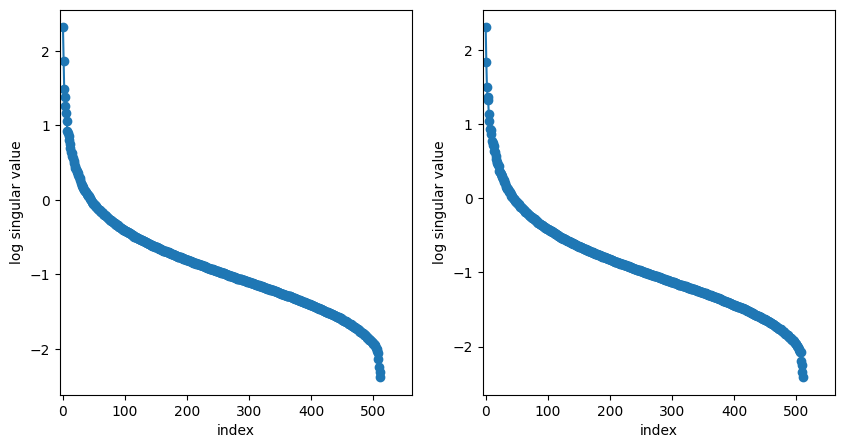

In [65]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(train_MLO_features).plot_scree(log = True)
plt.subplot(1, 2, 2)
PCA().fit(train_CC_features).plot_scree(log = True)

In [66]:
aj = AJIVE(init_signal_ranks=[20,20], n_jobs=16, center=True)
aj.fit([train_MLO_features, train_CC_features])
aj.summary()


'AJIVE, joint rank: 6, view 0 indiv rank: 15, view 1 indiv rank: 14'

In [67]:
val_data = torch.load('saved_features/MLOvsCC/all_data_val.pt')
val_MLO_features = val_data['MLO_features'].numpy()
val_CC_features = val_data['CC_features'].numpy()
val_labels = val_data['labels'].numpy()

test_data = torch.load('saved_features/MLOvsCC/all_data_test.pt')
test_MLO_features = test_data['MLO_features'].numpy()
test_CC_features = test_data['CC_features'].numpy()
test_labels = test_data['labels'].numpy()

In [68]:
# Create enriched features with consistent transformations
train_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(train_MLO_features), aj.view_specific_[1].joint_.transform(train_CC_features)])
val_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(val_MLO_features), aj.view_specific_[1].joint_.transform(val_CC_features)])
test_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(test_MLO_features), aj.view_specific_[1].joint_.transform(test_CC_features)])

train_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(train_MLO_features), aj.view_specific_[1].individual_.transform(train_CC_features)])
val_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(val_MLO_features), aj.view_specific_[1].individual_.transform(val_CC_features)])
test_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(test_MLO_features), aj.view_specific_[1].individual_.transform(test_CC_features)])

# Combined enriched features (joint + individual)
train_cancer_enriched = np.hstack([train_joint_components, train_individual_components])
val_cancer_enriched = np.hstack([val_joint_components, val_individual_components])
test_cancer_enriched = np.hstack([test_joint_components, test_individual_components])

In [69]:
def compare_feature_transformations_svm_clean():
    """
    Clean version with execution tracking to prevent duplicate display
    """
    import time
    execution_id = int(time.time() * 1000) % 100000  # Unique 5-digit ID
    
    # Define feature sets to compare
    feature_sets = [
        ('MLO Features Only', train_MLO_features, val_MLO_features, test_MLO_features),
        ('CC Features Only', train_CC_features, val_CC_features, test_CC_features),
        ('Concatenated (MLO + CC)', 
         np.hstack([train_MLO_features, train_CC_features]),
         np.hstack([val_MLO_features, val_CC_features]),
         np.hstack([test_MLO_features, test_CC_features])),
        ('Joint Components Only', train_joint_components, val_joint_components, test_joint_components),
        ('Individual Components Only', train_individual_components, val_individual_components, test_individual_components),
        ('AJIVE Enriched (Joint + Individual)', train_cancer_enriched, val_cancer_enriched, test_cancer_enriched)
    ]
    
    # Store results
    all_results = []
    
    print(f"Execution ID: {execution_id}")
    print("Comparing Feature Transformations with RBF SVM...")
    print("=" * 70)
    
    for i, (feature_name, X_train, X_val, X_test) in enumerate(feature_sets):
        print(f"\n[{i+1}/{len(feature_sets)}] 🔍 {feature_name}")
        print(f"Dimensions: {X_train.shape[1]} | ID: {execution_id}")
        print("-" * 50)
        
        try:
            results, trained_svm = evaluate_svm_classifier(
                X_train, train_cancer_labels,
                X_val, val_labels,
                X_test, test_labels,
                feature_name
            )
            all_results.append(results)
            
            print(f" Accuracy: {results['test_acc_macro']:.4f} | F1: {results['test_f1_macro']:.4f}")
            print(f" CV: {results['cv_f1_mean']:.4f} ± {results['cv_f1_std']:.4f}")
            
        except Exception as e:
            print(f" ERROR: {str(e)}")
    
    print(f"\n Execution {execution_id} completed: {len(all_results)} evaluations")
    return all_results

# Execute the clean version
all_results = compare_feature_transformations_svm_clean()

print(f"\n Final Summary:")
print(f"Total results: {len(all_results)}")
for i, result in enumerate(all_results):
    print(f"  {i+1}. {result['feature_name']}: F1={result['test_f1_macro']:.4f}")

Execution ID: 99287
Comparing Feature Transformations with RBF SVM...

[1/6] 🔍 MLO Features Only
Dimensions: 512 | ID: 99287
--------------------------------------------------
 Accuracy: 0.2000 | F1: 0.0757
 CV: 0.3402 ± 0.0087

[2/6] 🔍 CC Features Only
Dimensions: 512 | ID: 99287
--------------------------------------------------
 Accuracy: 0.2000 | F1: 0.0757
 CV: 0.3332 ± 0.0097

[3/6] 🔍 Concatenated (MLO + CC)
Dimensions: 1024 | ID: 99287
--------------------------------------------------
 Accuracy: 0.2000 | F1: 0.0146
 CV: 0.3644 ± 0.0150

[4/6] 🔍 Joint Components Only
Dimensions: 12 | ID: 99287
--------------------------------------------------
 Accuracy: 0.2004 | F1: 0.0155
 CV: 0.4088 ± 0.0096

[5/6] 🔍 Individual Components Only
Dimensions: 29 | ID: 99287
--------------------------------------------------
 Accuracy: 0.2000 | F1: 0.0757
 CV: 0.4733 ± 0.0108

[6/6] 🔍 AJIVE Enriched (Joint + Individual)
Dimensions: 41 | ID: 99287
--------------------------------------------------


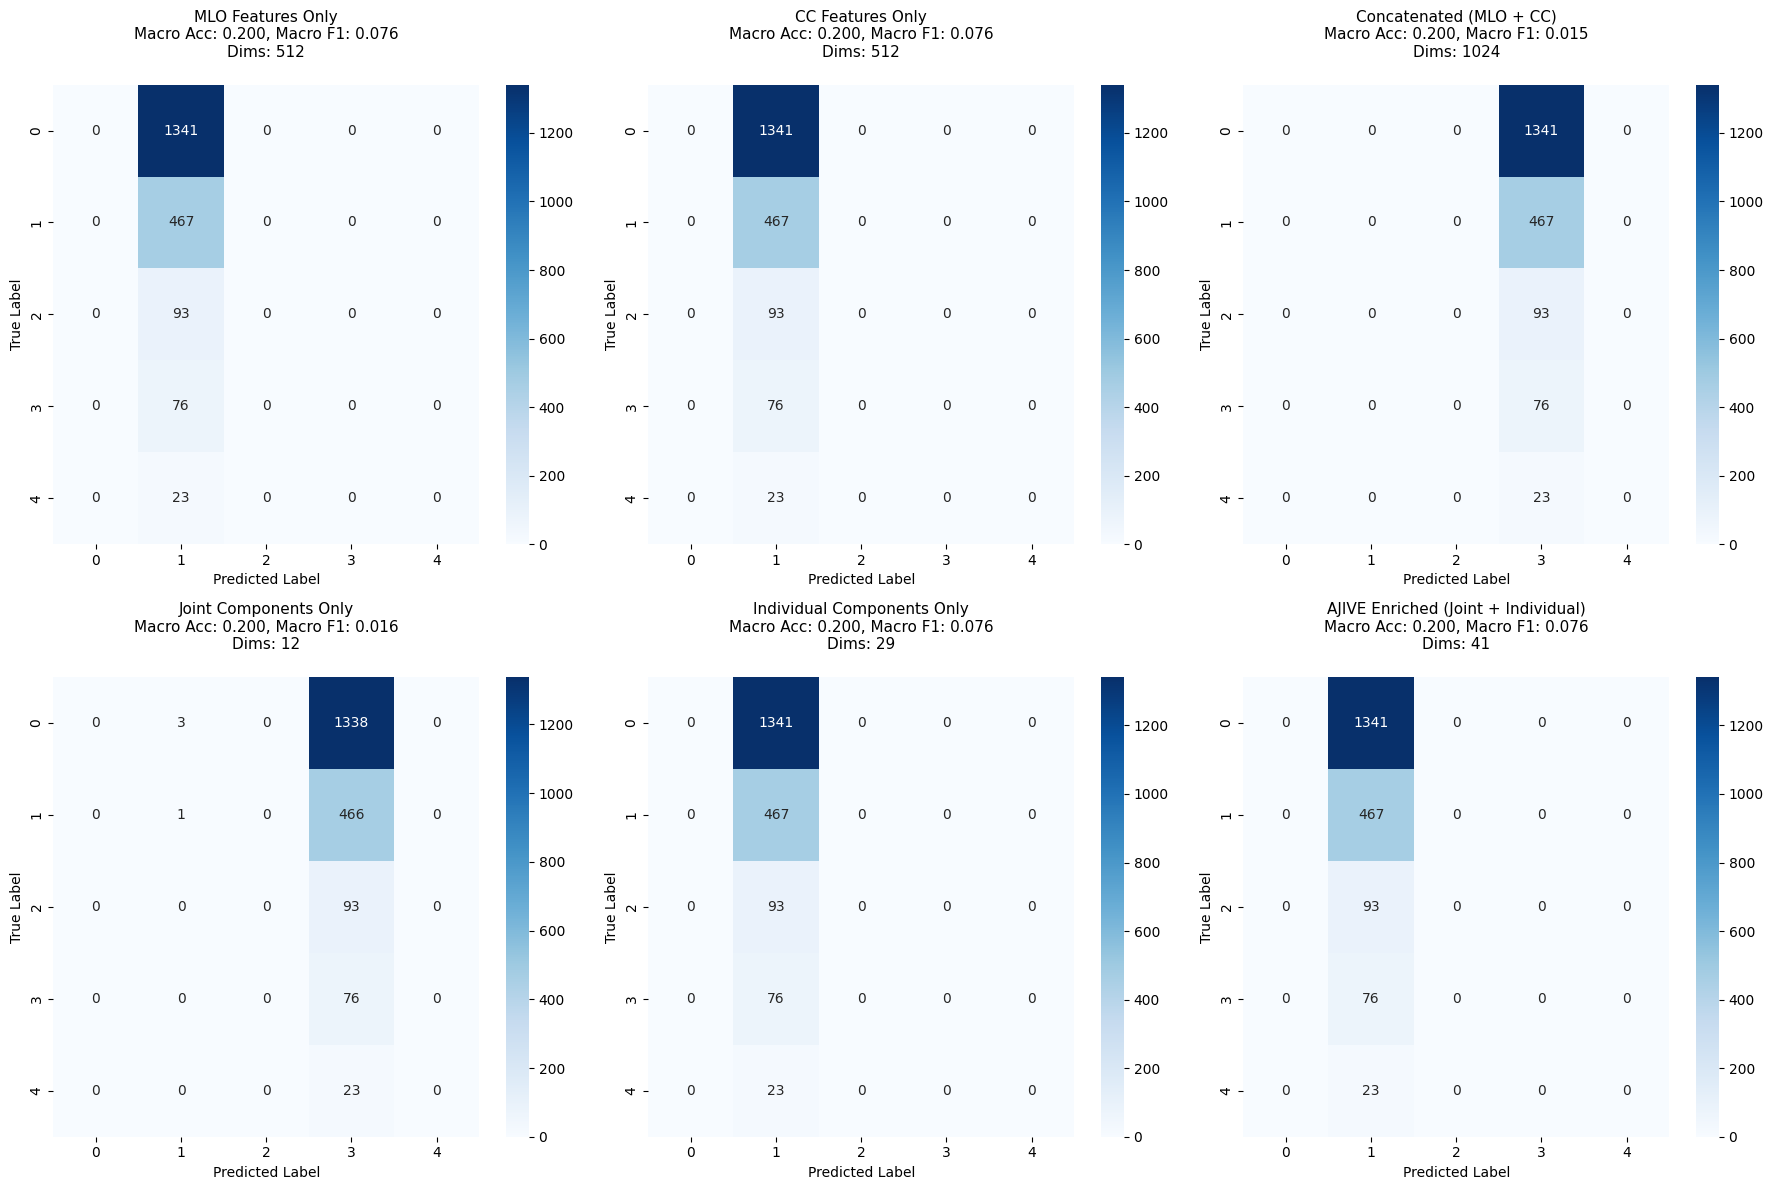

In [70]:
confusion_fig = plot_confusion_matrices_comparison(all_results)